In [1]:
import os, fnmatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from scipy.misc import imresize
import cv2

%matplotlib inline

target_size = (32,96) # aligning with pix per cell size 

def find_files(directory, pattern): # from stackoverflow
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename

def image_in_list(img):
    res = cv2.resize(img, target_size, interpolation = cv2.INTER_CUBIC)
    return res
        
def load_and_extract(directory, fn_handler, feature_list):
    shape = None        
    cnt = 0
    
    for filename in find_files(directory, '*.jpg'):
        cnt += 1
        img = plt.imread(filename)
        
        if len(img.shape) > 2 and img.shape[2] == 4:
            #converthe image from RGBA2RGB
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        
        img_2 = cv2.resize(img, target_size, interpolation = cv2.INTER_CUBIC)
             
        feature_list.append(fn_handler(img_2))
        

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [84]:
def create_model(input_shape=(48,16,3)):
    model = Sequential()
    # Center and normalize our data
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    # 1st conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))  
    model.add(Dropout(0.5))
    # 2nd conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(Dropout(0.5))
    # 3rd conv layer with 128 filter, 3x3 each, 8x8 pooling and dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.5))
    # This acts like a 128 neuron dense layer
    model.add(Convolution2D(128,6,2,activation="relu",name="dense1")) 
    model.add(Dropout(0.5))
    #model.add(Convolution2D(128,7,3,activation="relu",name="dense2")) 
    
    # This is like a 1 neuron dense layer with tanh [-1, 1]
    model.add(Convolution2D(1,1,1,name="dense3", activation="tanh")) 

    return model

model = create_model()
model.summary()
model.add(Flatten())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_28 (Lambda)               (None, 48, 16, 3)     0           lambda_input_28[0][0]            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 48, 16, 128)   3584        lambda_28[0][0]                  
____________________________________________________________________________________________________
dropout_109 (Dropout)            (None, 48, 16, 128)   0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 48, 16, 128)   147584      dropout_109[0][0]                
___________________________________________________________________________________________

In [85]:


X_pos = []
X_neg = []

resize = lambda image: cv2.resize(image, (16,48), interpolation = cv2.INTER_CUBIC)

load_and_extract('positives/', resize, X_pos)
load_and_extract('negatives', resize, X_neg)


Y = np.concatenate([np.ones(len(X_pos)), np.zeros(len(X_neg))])

X_pos.extend(X_neg)

X = np.array(X_pos)

# Split train and validation dataset with 10%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=63)

X.shape

(2084, 48, 16, 3)

Train on 1875 samples, validate on 209 samples
Epoch 1/10
111s - loss: 0.2755 - acc: 0.7755 - val_loss: 0.0174 - val_acc: 0.9569
Epoch 2/10
109s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3/10
104s - loss: 3.9958e-04 - acc: 1.0000 - val_loss: 2.7470e-04 - val_acc: 1.0000
Epoch 4/10
105s - loss: 2.2975e-04 - acc: 0.9995 - val_loss: 9.4821e-05 - val_acc: 1.0000
Epoch 5/10
103s - loss: 1.3098e-04 - acc: 1.0000 - val_loss: 2.8837e-05 - val_acc: 1.0000
Epoch 6/10
107s - loss: 4.3311e-05 - acc: 1.0000 - val_loss: 2.0918e-05 - val_acc: 1.0000
Epoch 7/10
104s - loss: 1.5344e-05 - acc: 1.0000 - val_loss: 7.8073e-06 - val_acc: 1.0000
Epoch 8/10
114s - loss: 6.6533e-06 - acc: 1.0000 - val_loss: 1.0453e-05 - val_acc: 1.0000
Epoch 9/10
103s - loss: 9.3920e-05 - acc: 1.0000 - val_loss: 1.8997e-07 - val_acc: 1.0000
Epoch 10/10
103s - loss: 7.4325e-06 - acc: 1.0000 - val_loss: 2.8653e-08 - val_acc: 1.0000


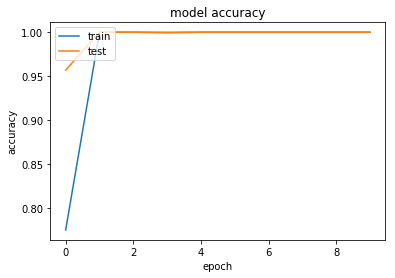

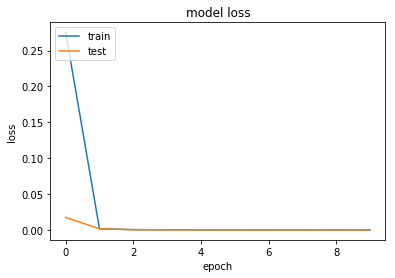

In [86]:
# Plot the results of the training
def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=128, nb_epoch=10, verbose=2, validation_data=(X_test, Y_test))

plot_results(history)

model.save_weights('./model.h5')

In [75]:
model.save_weights('./model.h5')

In [87]:
# Load the fine-tuned for the final network
model.load_weights('./model.h5')
print("Weights loaded!")


Weights loaded!


NN Prediction: TL with value 1.0
Ground-truth: TL with value 1.0


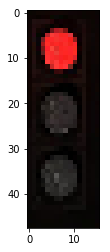

In [103]:
# Pick a random image from the test set
rand = np.random.randint(X_test.shape[0])
plt.imshow(X_test[rand])

# Predict the correct label
sample = np.reshape(X_test[rand], (1, 48,16,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
prediction = prediction[0][0]

# Check if the prediction is a car or a non-car
if prediction >= 0.5:
    print("NN Prediction: TL with value " + str(prediction))
else:
    print("NN Prediction: NO TL with value " + str(prediction))
    
# Compare with the ground-truth
truth = Y_test[rand]
if truth == 1:
    print("Ground-truth: TL with value " + str(truth))
else:
    print("Ground-truth: NO TL with value " + str(truth))

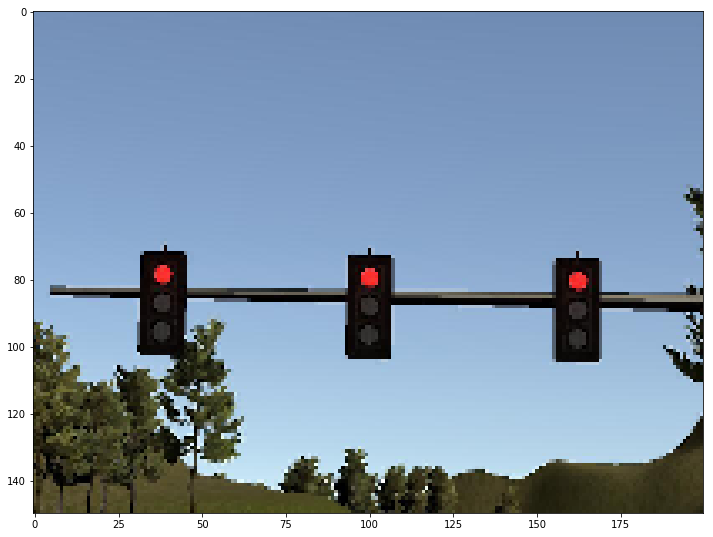

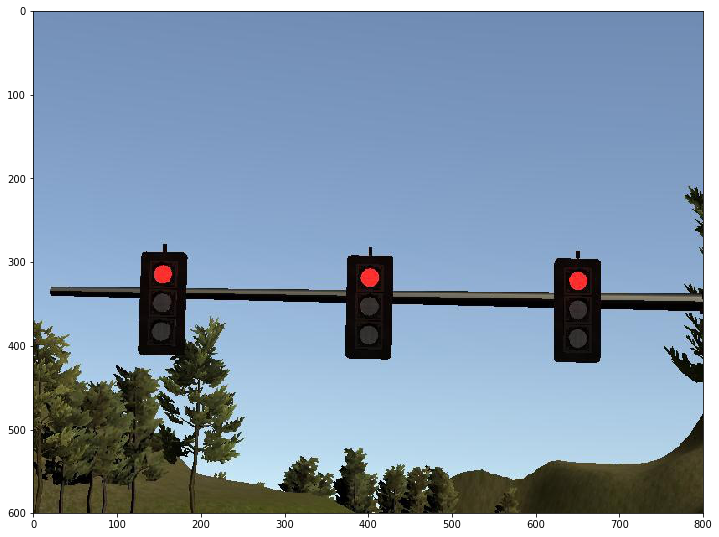

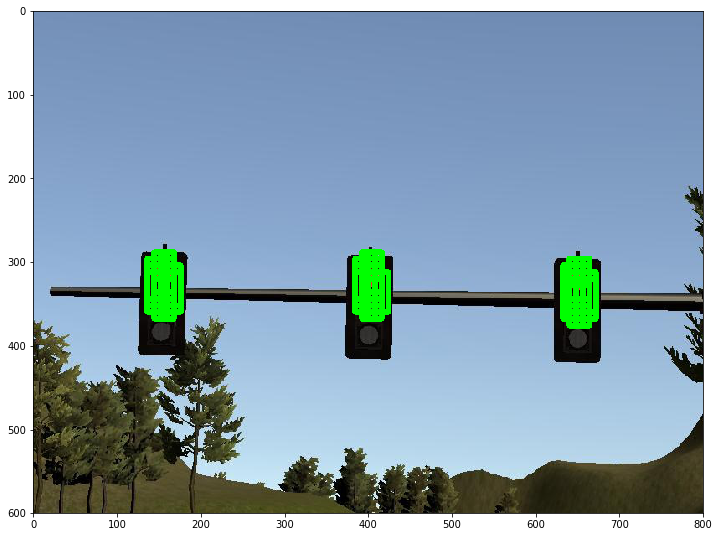

In [121]:
shp = (800,600)

# Load a specific sample image
img = plt.imread('./test_images_large/0_state_color_img.jpg')
#img = plt.imread('./annotated_images/green_102.jpg')
if len(img.shape) > 2 and img.shape[2] == 4:
    #converthe image from RGBA2RGB
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

img = cv2.resize(img, shp, interpolation = cv2.INTER_CUBIC)

# Display it
fig = plt.figure(figsize=(12,20))
plt.imshow(img)


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def search_cars(img):
    
    heat = heatmodel.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
    
    # This finds us rectangles that gre interesting
    xx, yy = np.meshgrid(np.arange(heat.shape[2]),np.arange(heat.shape[1]))
    x = (xx[heat[0,:,:,0]>0.9999])
    y = (yy[heat[0,:,:,0]>0.9999])
    hot_windows = []
    # We save those rects in a list
    for i,j in zip(x,y):
        hot_windows.append(((i*8, j*8), (i*8+16,j*8+48)))
    return hot_windows

# Init a version of our network with another resolution without the flatten layer
heatmodel = create_model((shp[1], shp[0], 3))
# Load the weights
heatmodel.load_weights('./model.h5')

# Search for our windows
hot_windows = search_cars(img)

# Draw the found boxes on the test image
window_img = draw_boxes(img, hot_windows, (0, 255, 0), 6)                    

# Show the image with the windows on top
fig = plt.figure(figsize=(12,20))
plt.imshow(window_img)